In [1]:
!wget https://mcfp.felk.cvut.cz/publicDatasets/CTU-13-Dataset/CTU-13-Dataset.tar.bz2

--2024-07-16 12:07:02--  https://mcfp.felk.cvut.cz/publicDatasets/CTU-13-Dataset/CTU-13-Dataset.tar.bz2
Resolving mcfp.felk.cvut.cz (mcfp.felk.cvut.cz)... 147.32.82.194
Connecting to mcfp.felk.cvut.cz (mcfp.felk.cvut.cz)|147.32.82.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1997547391 (1.9G) [application/x-bzip2]
Saving to: ‘CTU-13-Dataset.tar.bz2’

CTU-13-Dataset.tar. 100%[===================>]   1.86G  9.75MB/s    in 3m 12s  

2024-07-16 12:10:15 (9.93 MB/s) - ‘CTU-13-Dataset.tar.bz2’ saved [1997547391/1997547391]



In [3]:
!tar -xvjf CTU-13-Dataset.tar.bz2

CTU-13-Dataset/
CTU-13-Dataset/4/
CTU-13-Dataset/4/botnet-capture-20110815-rbot-dos.pcap
CTU-13-Dataset/4/capture20110815.binetflow
CTU-13-Dataset/4/README
CTU-13-Dataset/4/rbot.exe
CTU-13-Dataset/1/
CTU-13-Dataset/1/Neris.exe
CTU-13-Dataset/1/README.html
CTU-13-Dataset/1/capture20110810.binetflow
CTU-13-Dataset/1/botnet-capture-20110810-neris.pcap
CTU-13-Dataset/12/
CTU-13-Dataset/12/botnet-capture-20110819-bot.pcap
CTU-13-Dataset/12/capture20110819.binetflow
CTU-13-Dataset/12/README
CTU-13-Dataset/12/3d3d%3F%3F%3F%3F.xls.exe
CTU-13-Dataset/7/
CTU-13-Dataset/7/sogou_explorer_silent_1.4.0.418_2136.exe
CTU-13-Dataset/7/botnet-capture-20110816-sogou.pcap
CTU-13-Dataset/7/capture20110816-2.binetflow
CTU-13-Dataset/7/README
CTU-13-Dataset/8/
CTU-13-Dataset/8/capture20110816-3.binetflow
CTU-13-Dataset/8/QvodSetuPuls23.exe
CTU-13-Dataset/8/botnet-capture-20110816-qvod.pcap
CTU-13-Dataset/8/README
CTU-13-Dataset/5/
CTU-13-Dataset/5/botnet-capture-20110815-fast-flux.pcap
CTU-13-Dataset/5/e4f81

In [4]:
# Tentukan path file sumber dan path tujuan
source_file = 'CTU-13-Dataset/3/capture20110812.binetflow'
destination_file = 'dataset3.binetflow'

# Jalankan perintah cp melalui shell
!cp {source_file} {destination_file}

print(f"File telah disalin ke {destination_file}")


File telah disalin ke dataset3.binetflow


In [3]:
!pip install tables

  Using cached tables-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached numexpr-2.10.1-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.2 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached blosc2-2.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached ndindex-1.8-py3-none-any.whl.metadata (3.4 kB)
Using cached tables-3.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.5 MB)
Using cached blosc2-2.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.4 MB)
Using cached numexpr-2.10.1-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (405 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
Using cached ndindex-1.8-py3-none-any.whl (91 kB)


In [2]:
import pandas as pd
import numpy as np
import datetime
import h5py
from scipy.stats import mode
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import model_selection, feature_selection, utils, ensemble, linear_model, metrics

window_width = 120 # seconds
window_stride = 60 # seconds
print(pd.__version__)

2.0.3


In [6]:
data = pd.read_csv("dataset3.binetflow")

In [7]:
def normalize_column(dt, column):
    mean = dt[column].mean()
    std = dt[column].std()
    print(mean, std)

    dt[column] = (dt[column]-mean) / std

In [8]:
#mengubah kolom starttime menjadi datetime menjadi integer yang mewakili nanodetik sejak epoch (1970-01-01 00:00:00 UTC)
#dan mengkonversinya menjadi detik
data['StartTime'] = pd.to_datetime(data['StartTime']).astype(np.int64)*1e-9
datetime_start = data['StartTime'].min()

In [9]:
data['Window_lower'] = (data['StartTime']-datetime_start-window_width)/window_stride+1
data['Window_lower'].clip(lower=0, inplace=True)
data['Window_upper_excl'] = (data['StartTime']-datetime_start)/window_stride+1
data = data.astype({"Window_lower": int, "Window_upper_excl": int})
data.drop('StartTime', axis=1, inplace=True)

In [10]:
unique_lower = data['Window_lower'].max()
unique_upper = data['Window_upper_excl'].max()

In [11]:
data['Label'], labels = pd.factorize(data['Label'].str.slice(0, 15))

In [12]:
unique_labels = data['Label'].unique()

In [13]:
#print(data.dtypes)
Xi = pd.DataFrame() #membuat data frame kosong
Xo = pd.DataFrame()
nb_windows = data['Window_upper_excl'].max()

In [14]:
# mengelompokkan data dari address yang sama
for i in range(0, nb_windows):
    gb = data.loc[(data['Window_lower'] <= i) & (data['Window_upper_excl'] > i)].groupby('SrcAddr')
    Xi = pd.concat([Xi,gb.agg({'Sport':'nunique',
                                                       'DstAddr':'nunique',
                                                       'Dport':'nunique',
                                                       'Dur':['sum', 'mean', 'std', 'max', 'median'],
                                                       'TotBytes':['sum', 'mean', 'std', 'max', 'median'],
                                                       'SrcBytes':['sum', 'mean', 'std', 'max', 'median'],
                                                       'Label':lambda x: mode(x)[0]}).reset_index().assign(window_id=i)])
    Xo=pd.concat([Xo,gb.size().to_frame(name='counts')])

In [15]:
Xi.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in Xi.columns.values]
Xi = Xi.drop(columns=['SrcAddr_'])

In [16]:
Xo = Xo.reset_index()
Xi = Xi.reset_index()
result = pd.concat([Xo.reset_index(drop=True), Xi.reset_index(drop=True)], axis=1)

In [17]:
result = result.drop(columns=['index'])

In [18]:
#mengisi NaN dengan -1
result.fillna(-1, inplace=True)

In [19]:
columns_to_normalize = list(result.columns.values)
columns_to_normalize.remove('SrcAddr')
columns_to_normalize.remove('Label_<lambda>')
columns_to_normalize.remove('window_id_')

normalize_column(result, columns_to_normalize)
#normalisasi kecuali kolom tertentu

counts                  4.653001
Sport_nunique           3.990277
DstAddr_nunique         1.493815
Dport_nunique           1.586069
Dur_sum               827.470732
Dur_mean              589.578809
Dur_std                32.791083
Dur_max               635.657827
Dur_median            583.326355
TotBytes_sum       120021.740889
TotBytes_mean       43718.330005
TotBytes_std        24729.081224
TotBytes_max        91182.035603
TotBytes_median     37309.170603
SrcBytes_sum        31776.700218
SrcBytes_mean       14299.186517
SrcBytes_std         8139.303522
SrcBytes_max        29258.596695
SrcBytes_median     11778.931615
dtype: float64 counts             1.250211e+02
Sport_nunique      4.715955e+01
DstAddr_nunique    9.235606e+00
Dport_nunique      1.187169e+02
Dur_sum            5.050917e+03
Dur_mean           1.132974e+03
Dur_std            2.250292e+02
Dur_max            1.185246e+03
Dur_median         1.137732e+03
TotBytes_sum       8.459116e+06
TotBytes_mean      4.396375e+06
TotByt

In [22]:
result.drop('SrcAddr', axis=1).to_hdf('data_window_botnet3.h5', key="data", mode="w")
np.save("data_window_botnet3_id.npy", result['SrcAddr'])
np.save("data_window_botnet3_labels.npy", labels)

In [23]:
print(data)

                Dur Proto          SrcAddr  Sport    Dir         DstAddr  \
0         11.337043   tcp     195.68.34.68  52475     ->   147.32.86.165   
1          2.962470   tcp     147.32.86.58   1393     ->    77.75.73.156   
2          2.962828   tcp    201.54.33.206   2550     ->   147.32.86.110   
3          1.986249   tcp  221.134.221.114   8204     ->   147.32.84.189   
4        767.978638   tcp     147.32.84.59  49156     ->     147.32.80.7   
...             ...   ...              ...    ...    ...             ...   
4710633    0.002210   udp      147.32.85.2  55572    <->     147.32.80.9   
4710634    0.000312   udp      147.32.85.2  61416    <->     147.32.80.9   
4710635    0.006138   tcp      147.32.85.2  49590     ->  195.113.232.98   
4710636    0.000549   udp    89.176.63.143  27520    <->   147.32.84.229   
4710637    0.000358   udp    81.33.153.210  20176    <->   147.32.84.229   

         Dport      State  sTos  dTos  TotPkts  TotBytes  SrcBytes  Label  \
0        1

In [24]:
#entropi
def RU(df):
    if df.shape[0] == 1:
        return 1.0
    else:
        proba = df.value_counts()/df.shape[0]
        h = proba*np.log10(proba)
        return -h.sum()/np.log10(df.shape[0])

In [25]:
X = pd.DataFrame()
nb_windows = data['Window_upper_excl'].max()

for i in range(0, nb_windows):
    gc = data.loc[(data['Window_lower'] <= i) & (data['Window_upper_excl'] > i)].groupby('SrcAddr')
    X = pd.concat([X,gc.agg({'Sport':[RU],
                         'DstAddr':[RU],
                         'Dport':[RU]}).reset_index()])

In [26]:
print(X)

               SrcAddr Sport DstAddr Dport
                          RU      RU    RU
0              0.0.0.0   1.0     1.0   1.0
1    00:15:17:2c:e5:2d   1.0     1.0   1.0
2      106.158.147.110   1.0     1.0   1.0
3           108.6.32.7   1.0     1.0   1.0
4       109.110.228.27   1.0     1.0   1.0
..                 ...   ...     ...   ...
396     98.174.222.196   1.0     1.0   1.0
397      98.207.48.170   1.0     1.0   1.0
398      99.194.12.182   1.0     1.0   1.0
399       99.254.70.11   1.0     1.0   1.0
400       99.34.187.14   1.0     1.0   1.0

[2024053 rows x 4 columns]


In [27]:
X.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in X.columns.values]
columns_to_normalize = list(X.columns.values)
columns_to_normalize.remove('SrcAddr_')

normalize_column(X, columns_to_normalize)

Sport_RU      0.964012
DstAddr_RU    0.882071
Dport_RU      0.880979
dtype: float64 Sport_RU      0.174145
DstAddr_RU    0.307635
Dport_RU      0.309181
dtype: float64


In [28]:
print(X)

              SrcAddr_  Sport_RU  DstAddr_RU  Dport_RU
0              0.0.0.0  0.206657    0.383341  0.384955
1    00:15:17:2c:e5:2d  0.206657    0.383341  0.384955
2      106.158.147.110  0.206657    0.383341  0.384955
3           108.6.32.7  0.206657    0.383341  0.384955
4       109.110.228.27  0.206657    0.383341  0.384955
..                 ...       ...         ...       ...
396     98.174.222.196  0.206657    0.383341  0.384955
397      98.207.48.170  0.206657    0.383341  0.384955
398      99.194.12.182  0.206657    0.383341  0.384955
399       99.254.70.11  0.206657    0.383341  0.384955
400       99.34.187.14  0.206657    0.383341  0.384955

[2024053 rows x 4 columns]


In [29]:
X.drop('SrcAddr_', axis=1).to_hdf('data_window3_botnet3.h5', key="data", mode="w")
np.save("data_window_botnet3_id3.npy", X['SrcAddr_'])
np.save("data_window_botnet3_labels3.npy", labels)

**TRAINING**

In [30]:
data1 = pd.read_hdf('data_window_botnet3.h5', key='data')
data1.reset_index(drop=True, inplace=True)

data2 = pd.read_hdf('data_window3_botnet3.h5', key='data')
data2.reset_index(drop=True, inplace=True)

In [31]:
data = pd.concat([data1, data2], axis=1) #menggabungkan data

In [32]:
print(data)

           counts  Sport_nunique  DstAddr_nunique  Dport_nunique   Dur_sum  \
0       -0.029219      -0.063408        -0.053469      -0.004937  0.546187   
1       -0.029219      -0.084612        -0.053469      -0.013360  0.548073   
2       -0.029219      -0.063408        -0.053469      -0.004937 -0.160237   
3       -0.029219      -0.063408        -0.053469      -0.004937  0.447344   
4       -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
...           ...            ...              ...            ...       ...   
2024048 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
2024049 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
2024050 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
2024051 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
2024052 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   

         Dur_mean   Dur_std   Dur_max  Dur_median  TotBytes_sum

In [33]:
data.drop('window_id_', axis=1, inplace=True)

y = data['Label_<lambda>']
data.drop('Label_<lambda>', axis=1, inplace=True)

labels = np.load('data_window_botnet3_labels.npy',allow_pickle=True)

print(data.columns.values)
print(labels)
print(np.where(labels == 'flow=From-Botne')[0][0])

['counts' 'Sport_nunique' 'DstAddr_nunique' 'Dport_nunique' 'Dur_sum'
 'Dur_mean' 'Dur_std' 'Dur_max' 'Dur_median' 'TotBytes_sum'
 'TotBytes_mean' 'TotBytes_std' 'TotBytes_max' 'TotBytes_median'
 'SrcBytes_sum' 'SrcBytes_mean' 'SrcBytes_std' 'SrcBytes_max'
 'SrcBytes_median' 'Sport_RU' 'DstAddr_RU' 'Dport_RU']
['flow=Background' 'flow=From-Norma' 'flow=Normal-V44' 'flow=From-Backg'
 'flow=To-Backgro' 'flow=To-Normal-' 'flow=From-Botne']
6


In [34]:
y_bin6 = y==np.where(labels == 'flow=From-Botne')[0][0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, y_bin6, test_size=0.33, random_state=123456)

1009
2024053


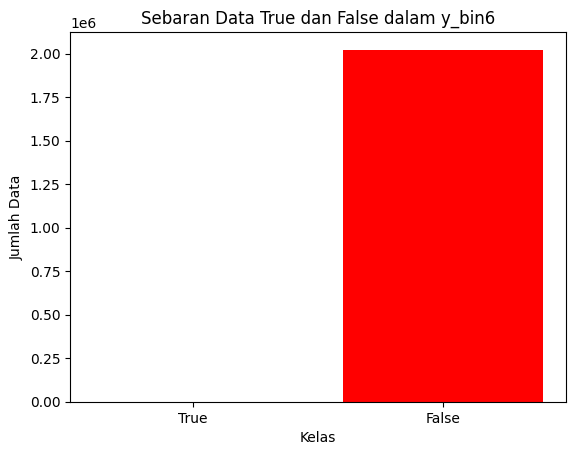

In [35]:
# Hitung jumlah True dan False
true_count = y_bin6.sum()
false_count = len(y_bin6) - true_count
print(true_count)
print(y_bin6.size)
# Plot sebaran
plt.bar(['True', 'False'], [true_count, false_count], color=['blue', 'red'])
plt.title('Sebaran Data True dan False dalam y_bin6')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Data')
plt.show()

In [36]:
print(X_train.shape)
X_train_new, y_train_new = utils.resample(X_train, y_train, n_samples=X_train.shape[0]*20, random_state=123456)

print("y", np.unique(y, return_counts=True))
print("y_train", np.unique(y_train_new, return_counts=True))
print("y_test", np.unique(y_test, return_counts=True))


(1356115, 22)
y (array([0, 1, 2, 3, 4, 5, 6]), array([1903499,    5483,       5,     986,  112392,     679,    1009]))
y_train (array([False,  True]), array([27109184,    13116]))
y_test (array([False,  True]), array([667591,    347]))


In [38]:
## Embedded Method
print("Random Forest Classifier")

clf = ensemble.RandomForestClassifier(
    n_estimators=100, 
    random_state=123456, 
    verbose=1, 
    class_weight=None, 
    n_jobs=-1  # Menambahkan parameter n_jobs
)
clf.fit(X_train_new, y_train_new)

Random Forest Classifier


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 21.6min finished


RandomForestClassifier(n_jobs=-1, random_state=123456, verbose=1)

In [39]:
print("Train")
y_pred_train = clf.predict(X_train_new)
print("accuracy score = ", metrics.balanced_accuracy_score(y_train_new, y_pred_train))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_train_new, y_pred_train)
print("precision = ", precision[1])
print("recall = ", recall[1])
print("fbeta_score = ", fbeta_score[1])
print("support = ", support[1])

Train


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.8s finished


accuracy score =  0.9929094236047575
precision =  1.0
recall =  0.9858188472095151
fbeta_score =  0.9928587882976273
support =  13116


In [40]:
print("Test")
y_pred_test = clf.predict(X_test)
print("accuracy score = ", metrics.balanced_accuracy_score(y_test, y_pred_test))
precision, recall, fbeta_score, support = metrics.precision_recall_fscore_support(y_test, y_pred_test)
print("precision = ", precision[1])
print("recall = ", recall[1])
print("fbeta_score = ", fbeta_score[1])
print("support = ", support[1])

Test


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished


accuracy score =  0.9827089337175792
precision =  1.0
recall =  0.9654178674351584
fbeta_score =  0.9824046920821115
support =  347


In [ ]:
feature_importances = clf.feature_importances_
feature_names = data.columns

In [ ]:
feature_importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Mengurutkan berdasarkan importansi
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Tampilkan tingkat kepentingan fitur
print(feature_importances_df)

            feature  importance
14     SrcBytes_sum    0.097121
0            counts    0.086464
1     Sport_nunique    0.078776
12     TotBytes_max    0.064442
13  TotBytes_median    0.056678
19         Sport_RU    0.055982
16     SrcBytes_std    0.052271
18  SrcBytes_median    0.050797
17     SrcBytes_max    0.048622
8        Dur_median    0.044543
20       DstAddr_RU    0.044219
15    SrcBytes_mean    0.041778
21         Dport_RU    0.037402
4           Dur_sum    0.036413
9      TotBytes_sum    0.031445
10    TotBytes_mean    0.030191
7           Dur_max    0.028992
6           Dur_std    0.028219
5          Dur_mean    0.027507
11     TotBytes_std    0.024683
2   DstAddr_nunique    0.017704
3     Dport_nunique    0.015751


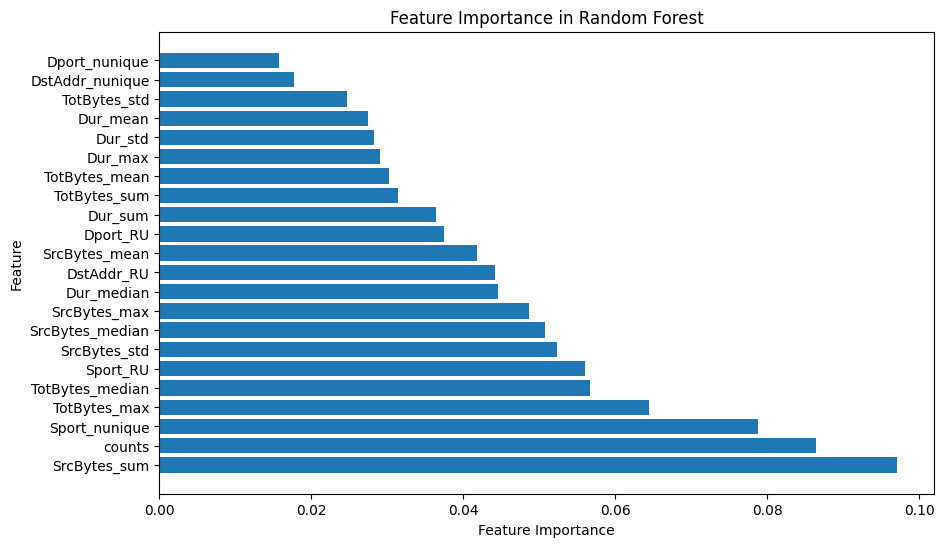

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['feature'], feature_importances_df['importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.show()

In [13]:
d1 = pd.read_hdf('data_window_botnet3.h5', key='data')
d1.reset_index(drop=True, inplace=True)

d2 = pd.read_hdf('data_window3_botnet3.h5', key='data')
d2.reset_index(drop=True, inplace=True)

d3 = np.load('data_window_botnet3_id.npy',allow_pickle=True)

d4 = np.load('data_window_botnet3_id3.npy', allow_pickle=True)

d5 = np.load('data_window_botnet3_labels.npy',allow_pickle=True)

d6 = np.load('data_window_botnet3_labels3.npy',allow_pickle=True)

In [14]:
print(d1,d2)

           counts  Sport_nunique  DstAddr_nunique  Dport_nunique   Dur_sum  \
0       -0.029219      -0.063408        -0.053469      -0.004937  0.546187   
1       -0.029219      -0.084612        -0.053469      -0.013360  0.548073   
2       -0.029219      -0.063408        -0.053469      -0.004937 -0.160237   
3       -0.029219      -0.063408        -0.053469      -0.004937  0.447344   
4       -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
...           ...            ...              ...            ...       ...   
2024048 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
2024049 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
2024050 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
2024051 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   
2024052 -0.029219      -0.063408        -0.053469      -0.004937 -0.163826   

         Dur_mean   Dur_std   Dur_max  Dur_median  TotBytes_sum

In [15]:
print(d3)

['0.0.0.0' '00:15:17:2c:e5:2d' '106.158.147.110' ... '99.194.12.182'
 '99.254.70.11' '99.34.187.14']


In [16]:
print(d4)

['0.0.0.0' '00:15:17:2c:e5:2d' '106.158.147.110' ... '99.194.12.182'
 '99.254.70.11' '99.34.187.14']


In [17]:
print(d5)

['flow=Background' 'flow=From-Norma' 'flow=Normal-V44' 'flow=From-Backg'
 'flow=To-Backgro' 'flow=To-Normal-' 'flow=From-Botne']


In [18]:
print(d6)

['flow=Background' 'flow=From-Norma' 'flow=Normal-V44' 'flow=From-Backg'
 'flow=To-Backgro' 'flow=To-Normal-' 'flow=From-Botne']
